1.0775681987404824
1.7578023754060268
1.1323088912273709
1.5610093417425204


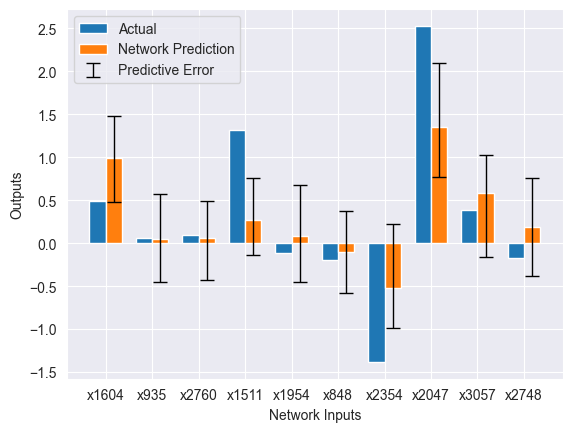

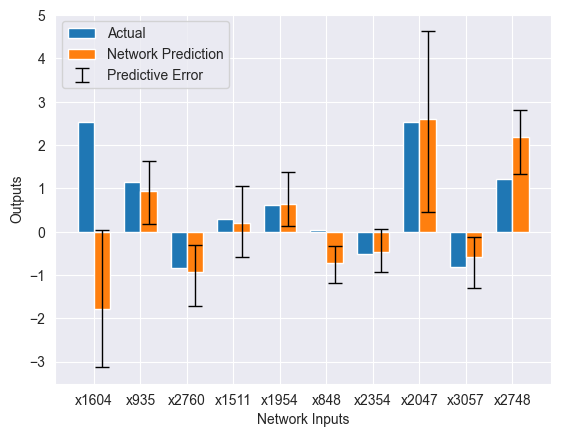

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
from neural_net.get_data import get_training_data, get_test_data
from utils.helper_functions import subsample
from plotting.plotting_helpers import two_variable_bar_plot

sns.set_style('darkgrid')

x_train, y_train = get_training_data('../configs/nn_config.ini')
x_test, y_test = get_test_data('../configs/nn_config.ini')

# split test data into those inside and outside 1 std deviation from mean for each dimension
x_mean = np.mean(x_train, axis=0)
x_var = np.var(x_train, axis=0)
upper = x_mean + np.sqrt(x_var)
lower = x_mean - np.sqrt(x_var)
upper_truth = [all(x_test[i] < upper) for i in range(x_test.shape[0])]
lower_truth = [all(x_test[i] > lower) for i in range(x_test.shape[0])]
truth = np.logical_and(upper_truth, lower_truth)
x_test_inner, y_test_inner = x_test[truth], y_test[truth].squeeze(-1)
x_test_outer, y_test_outer = x_test[np.logical_not(truth)], y_test[np.logical_not(truth)].squeeze(-1)

# get sghmc predictive samples
sghmc_predictive_samples = pd.read_csv('../test_samples/nn/sghmc_pred.csv').to_numpy().T
sghmc_predictive_samples_inner = sghmc_predictive_samples[truth]
sghmc_predictive_samples_outer = sghmc_predictive_samples[np.logical_not(truth)]

# get ls predictive samples
ls_predictive_samples = pd.read_csv('../test_samples/nn/ls_pred.csv').to_numpy().T

# get old predictive samples
sghmc_old_predictive_samples = pd.read_csv('../test_samples/nn/sghmc_pred_old.csv').to_numpy().T

# get net predictions
net_predictions = pd.read_csv('../test_samples/nn/sghmc_pred_net_predictions.csv')["predictions"].to_numpy()
net_predictions_inner = net_predictions[truth]
net_predictions_outer = net_predictions[np.logical_not(truth)]

# get number of ll samples & set number of variables to show
num_ll_samples = sghmc_predictive_samples_inner.shape[-1]
num_display_data = 10

# subsample inner data
idx = subsample(x_test_inner.shape[0], x_test_inner.shape[0]/num_display_data)
net_predictions_inner_sub = net_predictions_inner[idx]
y_test_inner_sub = y_test_inner[idx]
predictive_samples_inner_sub = sghmc_predictive_samples_inner[idx]

# subsample outer data
idx = subsample(x_test_outer.shape[0], x_test_outer.shape[0]/num_display_data)
net_predictions_outer_sub = net_predictions_outer[idx]
y_test_outer_sub = y_test_outer[idx]
predictive_samples_outer_sub = sghmc_predictive_samples_outer[idx]

# set inner errors
inner_errors = np.resize(net_predictions_inner_sub, (num_ll_samples, num_display_data)) - predictive_samples_inner_sub.T
inner_min_errors = np.zeros(num_display_data)
inner_max_errors = np.zeros(num_display_data)
for i in range(num_display_data):
    inner_min_errors[i] = np.abs(np.min(inner_errors[:,i]))
    inner_max_errors[i] = np.abs(np.max(inner_errors[:,i]))

# set outer errors
outer_errors = np.resize(net_predictions_outer_sub, (num_ll_samples, num_display_data)) - predictive_samples_outer_sub.T
outer_min_errors = np.zeros(num_display_data)
outer_max_errors = np.zeros(num_display_data)
for i in range(num_display_data):
    outer_min_errors[i] = np.abs(np.min(outer_errors[:,i]))
    outer_max_errors[i] = np.abs(np.max(outer_errors[:,i]))
    
# set full outer errors
outer_errors_full = np.resize(net_predictions_outer, (num_ll_samples, sghmc_predictive_samples_outer.shape[0])) - sghmc_predictive_samples_outer.T
outer_min_errors_full = np.zeros(sghmc_predictive_samples_outer.shape[0])
outer_max_errors_full = np.zeros(sghmc_predictive_samples_outer.shape[0])
for i in range(sghmc_predictive_samples_outer.shape[0]):
    outer_min_errors_full[i] = np.abs(np.min(outer_errors_full[:,i]))
    outer_max_errors_full[i] = np.abs(np.max(outer_errors_full[:,i]))

# set full inner errors
inner_errors_full = np.resize(net_predictions_inner, (num_ll_samples, sghmc_predictive_samples_inner.shape[0])) - sghmc_predictive_samples_inner.T
inner_min_errors_full = np.zeros(sghmc_predictive_samples_inner.shape[0])
inner_max_errors_full = np.zeros(sghmc_predictive_samples_inner.shape[0])
for i in range(sghmc_predictive_samples_inner.shape[0]):
    inner_min_errors_full[i] = np.abs(np.min(inner_errors_full[:,i]))
    inner_max_errors_full[i] = np.abs(np.max(inner_errors_full[:,i]))
    
# generate inner plot
labels = [f"x{i}" for i in idx]
fig, ax = two_variable_bar_plot(
    labels, 
    y_test_inner_sub, 
    net_predictions_inner_sub, 
    error_min_2=inner_min_errors, 
    error_max_2=inner_max_errors, 
    xlabel='Network Inputs', 
    ylabel='Outputs', 
    var_labels=('Actual', 'Network Prediction'), 
    error_labels=('','Predictive Error')
)

# generate outer plot
labels = [f"x{i}" for i in idx]
fig, ax = two_variable_bar_plot(
    labels, 
    y_test_outer_sub, 
    net_predictions_outer_sub, 
    error_min_2=outer_min_errors, 
    error_max_2=outer_max_errors, 
    xlabel='Network Inputs', 
    ylabel='Outputs', 
    var_labels=('Actual', 'Network Prediction'), 
    error_labels=('','Predictive Error')
)

print(np.mean(np.abs(inner_max_errors + inner_min_errors)))
print(np.mean(np.abs(outer_max_errors + outer_min_errors)))
print(np.mean(np.abs(inner_max_errors_full + inner_min_errors_full)))
print(np.mean(np.abs(outer_max_errors_full + outer_min_errors_full)))

In [4]:
sghmc_vars = pd.read_csv('../test_samples/nn/sghmc_pred_vars.csv')["vars"].to_numpy()
sghmc_old_vars = pd.read_csv('../test_samples/nn/sghmc_pred_old_vars.csv')["vars"].to_numpy()
ls_vars = pd.read_csv('../test_samples/nn/ls_pred_vars.csv')["vars"].to_numpy()

In [5]:
num_subsets = 8
n = sghmc_predictive_samples.shape[0]
subset_sghmc_samples = np.array(np.split(sghmc_predictive_samples, 8, axis=-1))
subset_sghmc_old_samples = np.array(np.split(sghmc_old_predictive_samples, 8, axis=-1))
subset_ls_samples = np.array(np.split(ls_predictive_samples, 8, axis=-1))
empirical_sghmc_vars = np.std(subset_sghmc_samples, axis=-1)**2
empirical_sghmc_old_vars = np.std(subset_sghmc_old_samples, axis=-1)**2
empirical_ls_vars = np.std(subset_ls_samples, axis=-1)**2
sghmc_var_errors = np.mean((empirical_sghmc_vars - sghmc_vars)**2, axis=-1)
sghmc_old_var_errors = np.mean((empirical_sghmc_old_vars - sghmc_vars)**2, axis=-1)
ls_var_errors = np.mean((empirical_ls_vars - ls_vars)**2, axis=-1)

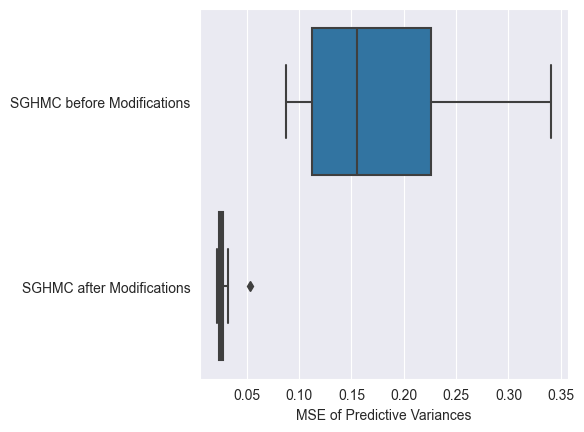

In [7]:
fig, ax = plt.subplots()
ax = sns.boxplot(
    data={
        'data': np.hstack((
            sghmc_old_var_errors,
            sghmc_var_errors,
            #ls_var_errors
        )), 
        'labels':np.hstack((
            np.full(num_subsets, 'SGHMC before Modifications'),
            np.full(num_subsets, 'SGHMC after Modifications'),
            #np.full(num_subsets, 'Least Squares Optimization Sampling')
    ))}, 
    x='data', 
    y='labels'
)
ax.set_xlabel("MSE of Predictive Variances")
plt.subplots_adjust(right=0.7)